In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

In [2]:
%%script false --no raise error
# Read files
with open("ttbar_file_complete.txt", "r") as f:
    files = [line.strip() for line in f if line.strip()]
    
    
tree_name = "Events"
df = ROOT.RDataFrame(tree_name, files)
print("Total entries:", df.Count().GetValue())

In [3]:
file = 'ttbar.root'
df = ROOT.RDataFrame("Events", file)

Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


In [4]:
# Define scuared generator weight to help compute error bars 
df = df.Define("genWeight2", "pow(genWeight, 2)")

In [5]:
# Function to if event has BHadrons
LeadHadron ="""
pair<int, float> LeadHadron(
ROOT::RVec<int> FlavourID, 
ROOT::RVec<float> ParticlePt)
{
    int nPart = FlavourID.size();
    int LeadId = 0;
    float LeadPt = 0.0;

    // Loop through particles
    for (int idx = 0; idx < nPart; idx++){
        int CandVal = FlavourID[idx];
        float CandPt = ParticlePt[idx];

        // Check if the particle is B hadron
        if ((abs(CandVal) >= 100 ) && (CandPt > LeadPt)){
            LeadId = CandVal;
            LeadPt = CandPt;
        }
    }
    return std::make_pair(LeadId, LeadPt);
}

"""

ROOT.gInterpreter.Declare(LeadHadron)

True

In [6]:
# Making a function to find b hadrons, since declaring std::vector breaks the backend somehow...
find_b_hadrons = """
bool FindB(
int LeadHadron_pdgId
){
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};
//bool IsMeson = std::find(Mesons.begin(), Mesons.end(), LeadHadron_pdgId) != Mesons.end();
bool IsMeson = (LeadHadron_pdgId <= -500 && LeadHadron_pdgId > -600);
bool IsBaryon = (LeadHadron_pdgId >= 5000 && LeadHadron_pdgId < 6000);
bool BExists = IsMeson || IsBaryon;
return BExists;
}
"""
ROOT.gInterpreter.Declare(find_b_hadrons)

True

In [7]:
# Trying to compute also these for scaling factor...
other_mesons = """
bool OtherMesons(
int LeadHadron_pdgId
){
std::vector<int> Mesons = {-511, -513, -521, -523, -531, -533};
bool IsMeson = std::find(Mesons.begin(), Mesons.end(), LeadHadron_pdgId) != Mesons.end();
if (IsMeson){
    return false;
}
else{
    return true;
}
}
"""
ROOT.gInterpreter.Declare(other_mesons)

True

In [8]:
# Define the leading hadron pdgId, pt, if it includes b quark and if it is some other b meson (should be neglible, but just to make sure)
df = (df.Define("LeadHadron", "LeadHadron(GenPart_pdgId, GenPart_pt)")
        .Define("LeadHadron_pdgId", "LeadHadron.first")
        .Define("LeadHadron_pt", "LeadHadron.second")
        .Define("HasB", "FindB(LeadHadron_pdgId)")
        .Define("HasOther", "OtherMesons(LeadHadron_pdgId)"))

In [9]:
# Create dataframes for reference values
df_BHad = df.Filter("HasB", "Filter events with B hadron")

In [10]:
# Computing and plotting production fractions and scaling factors
class Production():

    def __init__(self):
        self.Total_df = None    
        self.nTotal_array = None
        self.nTotal = None
        self.nTotal_w2 = None

        # Scalar
        self.production_fraction_pdg = {}
        self.errors_pdg = {}
        self.production_fraction_p8 = {}
        self.errors_p8 = {}
        self.colors = {}

        # pT dependent
        self.production_fraction_pt = {}
        self.errors_pt = {}
        self.nHadrons = {}
        self.scaling_factor = {}


    # Compute bin wise total for the hadrons in dataframe
    def Calculate_total(self, intervals, Total_df):
        # Bins
        self.intervals = np.array(intervals)
        self.bins = 0.5 * (self.intervals[:-1] + self.intervals[1:])

        # Store as a global value
        self.Total_df = Total_df

        # Histo for values
        h_total = Total_df.Histo1D(
            ("h_total", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
            "LeadHadron_pt", "genWeight"
        )

        # Histograms for weight^2 sums
        h_total_w2 = self.Total_df.Histo1D(
            ("h_total_w2", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
            "LeadHadron_pt", "genWeight2"
        )

        # Bin wise total and total
        self.nTotal_array = np.array([h_total.GetValue().GetBinContent(i+1) for i in range(len(intervals)-1)])
        self.nTotal = np.sum(self.nTotal_array)
        self.nTotal_w2 = np.array([h_total_w2.GetValue().GetBinContent(i+1) for i in range(len(intervals)-1)])



  # Add reference value and corresponding color
    def add_pdgPF(self, Name, val, err, color):
        self.production_fraction_pdg[Name] = val
        self.errors_pdg[Name] = err
        self.colors[Name] = color



    # Histo for production fractions (scalar)
    def production_fractions(self, list_pdgId, list_names, mesons):

        # Compute baryons
        df_Baryons = self.Total_df.Filter("LeadHadron_pdgId >= 5000 && LeadHadron_pdgId < 6000")
        n_baryons = df_Baryons.Sum("genWeight").GetValue()

        # Loop through every type of hadrons
        for ii in range(len(list_pdgId)):
            print(list_pdgId[ii] + "1")

            # For mesons we need to take into note also the excited particles
            if mesons[ii]:
                ground = list_pdgId[ii] + "1"
                excited = list_pdgId[ii] + "3"

                # Filter events with the corresponding hardest hadron
                df_frac = self.Total_df.Filter(f"LeadHadron_pdgId == {ground} || LeadHadron_pdgId == {excited}")

                # weighted yield of this species
                n_species = df_frac.Sum("genWeight").GetValue()

                frac = n_species / self.nTotal

            # For baryons more straightforward
            else:
                df_frac = self.Total_df.Filter(f"LeadHadron_pdgId == {list_pdgId[ii]}")
                n_species = df_frac.Sum("genWeight").GetValue()

                # Normalize fraction with respect to baryons
                frac = self.production_fraction_pdg['b-baryon'] * n_species / n_baryons    

            # Store to global values
            self.production_fraction_p8[list_names[ii]] = frac


        # Now plot: one bar per species
        fig, ax = plt.subplots(figsize=(7,5))

        # Compare achieved value to pdg
        x = np.arange(len(list_names))
        vals = [self.production_fraction_p8[name] for name in list_names]
        pdg_vals = [self.production_fraction_pdg[name] for name in list_names]
        pdg_err = [self.errors_pdg[name] for name in list_names]


        ax.bar(x, vals, color="#ffff33", edgecolor="black", width=1.0, align="center")

        # Overlay black points
        ax.errorbar(x, pdg_vals, yerr=pdg_err, fmt="o", color="black", capsize=3, capthick=1)

        # x-axis with labels
        ax.set_xticks(x)
        ax.set_xticklabels(list_names)

        # y-axis
        ax.set_ylabel("Fraction")
        ax.set_ylim(0, 0.6)

        # CMS label
        hep.cms.label(data=False, com = 13.6, year=2024, fontsize = 10)

        plt.tight_layout()
        plt.show()    


    # pT dependent production fraction for b hadrons
    def production_fractions_pt(self, list_pdgId, list_names, colors, Z = 1):
        hep.style.use("CMS")

        # Local dictionaries for bins, colors and array for cumulative
        bin_values = {}
        color_values = {}
        hist_values = np.zeros(len(self.bins))

        # Loop through every hadron in the list
        for ii in range(len(list_pdgId)):
            print(list_pdgId[ii])

            # Excited states, since we only consider mesons and leftower are assumed baryons
            ground = list_pdgId[ii] + "1"
            excited = list_pdgId[ii] + "3"

            # Filter
            df_frac = self.Total_df.Filter(f"LeadHadron_pdgId == {ground} || LeadHadron_pdgId == {excited}")

            # Histo
            h_pf = df_frac.Histo1D(
                ("h_pf", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
                "LeadHadron_pt", "genWeight"
            )

            # Activate lazy dataframe
            histo = h_pf.GetValue()

            # Extract values, production fractions and compute errors
            values = np.array([histo.GetBinContent(i+1) for i in range(len(self.intervals)-1)])
            fracs = values / self.nTotal_array
            Neff = self.nTotal_array**2 / self.nTotal_w2
            CI = Z * np.sqrt((fracs * (1 - fracs)) / Neff)

            # Store the values to global memory
            self.nHadrons[list_names[ii]] = values
            self.production_fraction_pt[list_names[ii]] = fracs
            self.errors_pt[list_names[ii]] = CI

            # Update the cumulative value
            hist_values = hist_values + fracs

            # Store the chosen color to global memory with the cumulative histogram values
            bin_values[list_names[ii]] = hist_values.tolist()
            color_values[list_names[ii]] = colors[ii]

        # Filter other mesons (should be negligible)
        df_frac = self.Total_df.Filter("HasOther")

        # Extract values and add to global dictionary
        h_pf = df_frac.Histo1D(
            ("h_pf", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
            "LeadHadron_pt", "genWeight"
        )
        histo = h_pf.GetValue()

        values = np.array([histo.GetBinContent(i+1) for i in range(len(self.intervals)-1)])

        self.nHadrons["OtherMesons"] = values

        # Plotting
        fig, ax = plt.subplots(figsize = (7,5))

        # Plot every meson on top of each other
        for ii, key in enumerate(bin_values.keys()):
            
            hep.histplot(
                bin_values[key],
                bins=self.intervals,
                histtype="fill",
                stack=True,
                color=color_values[key],
                label=key,
                zorder= -ii
            )

        # Rest are baryons
        baryon_fracs = [1 for ii in range(len(hist_values))]

        hep.histplot(
            baryon_fracs,
            bins=self.intervals,
            histtype="fill",
            stack=True,
            color= '#ffff33',
            label='b-baryons',
            zorder = -len(bin_values) 
        )

        #ax.set_xscale("log")
        ax.set_xlabel(r"$p_T^{\mathrm{gen\ hadron}}\ \mathrm{[GeV]}$", fontsize = 10)
        ax.set_ylabel("Production fraction", fontsize = 10)
        ax.set_xlim(self.intervals[0], self.intervals[-1])
        ax.set_ylim(0, 1)
        ax.legend()

        ax.legend(fontsize=9)
        ax.tick_params(axis='both', which='major', labelsize=8)  
        ax.tick_params(axis='both', which='minor', labelsize=6)

        hep.cms.label(data=False, com = 13.6, year=2024, fontsize = 10)
        plt.tight_layout()
        plt.show()


    # Helper function for computing the normalized fraction
    def compute_lambda(self, intervals, Z = 1):


        # Compute fraction for lambda
        df_Baryons = self.Total_df.Filter("LeadHadron_pdgId >= 5000 && LeadHadron_pdgId < 6000")
        df_Lambda = df_Baryons.Filter("LeadHadron_pdgId == 5122")

        # Histograms for baryons and lambda
        h_Bar = df_Baryons.Histo1D(
            ("h_Bar", "LeadHadron_pt", len(intervals)-1, intervals),
            "LeadHadron_pt", "genWeight"
        )   

        h_Bar_w2 = df_Baryons.Histo1D(
            ("h_Bar", "LeadHadron_pt", len(intervals)-1, intervals),
        "LeadHadron_pt", "genWeight2"
        )    

        h_Lam = df_Lambda.Histo1D(
            ("h_Lam", "LeadHadron_pt", len(self.intervals)-1, self.intervals),
            "LeadHadron_pt", "genWeight"
        )       

        # Activate lazy RDF
        baryons =  h_Bar.GetValue()
        baryons_w2 = h_Bar_w2.GetValue()
        Lambda = h_Lam.GetValue()
    
        # Extract
        nBaryons = np.array([baryons.GetBinContent(i+1) for i in range(len(intervals)-1)])
        nBaryons_w2 = np.array([baryons_w2.GetBinContent(i+1) for i in range(len(intervals)-1)])
        nLambda = np.array([Lambda.GetBinContent(i+1) for i in range(len(intervals)-1)])

        self.nHadrons[r'$\Lambda^0_b$'] = nLambda
        self.nHadrons['b-baryons'] = nBaryons - nLambda

        # Scale the Lambda by pdg value for baryons
        Baryons_pdg = self.production_fraction_pdg["b-baryon"]

        # Error bars
        Neff_Lam = nBaryons**2 / nBaryons_w2
        BF_Lam = Baryons_pdg * nLambda / nBaryons
        CI_Lam = Z * np.sqrt((BF_Lam * (1 - BF_Lam)) / Neff_Lam)


        return [BF_Lam, CI_Lam]
    



    # Reference function for gL (LHCb)
    def gL(self, x):
        return 8.02613e-2 + np.exp(-0.980386 - 0.110891 * x)


    # n = [n0, n+, n0s, nm, nLam, nb]
    # g = [g0s, gL]
    def scaling_factors(self, n, g):
        n_tot = np.sum(n)
        n0, nm, n0s, n_other, nLam, nb = n
        g0s, gL = g
        alpha = (g0s * nLam * n_other
                + g0s * nLam * n0s 
                + gL * n0s * nb 
                + gL * nLam * n0s 
                + nLam * n0s)
    
        print(n_tot)
        
        c0p = nLam * n0s * n_tot / ((n0 + nm) * alpha)
        c0s = g0s * nLam * n_tot / alpha
        cLb = gL * n0s * n_tot / alpha
        return [c0p, c0s, cLb]



    # Utilizes the previous function to compute all scaling factors
    def compute_scaling_factors(self):

        # Reference values
        g0s = 0.117857 * np.ones(len(self.bins))
        gL = np.array(self.gL(self.bins))
        g = [g0s, gL]

        # Extract number of hadrons (bin wise)
        n = list(self.nHadrons.values())

        # Scaling factors from the function and add to globad
        scaling_factors = self.scaling_factors(n, g)
        self.scaling_factor[r'$c_{0,p}$'] = scaling_factors[0]
        self.scaling_factor[r'$c_{0s,m}$'] = scaling_factors[1]
        self.scaling_factor[r'$c_{\Lambda_b,b}$'] = scaling_factors[2]

        # Append scaling factors into text file 
        with open('scaling_factors.txt', 'a') as f:
            for key, val_list in self.scaling_factor.items():
                val_str = ','.join(map(str, val_list))
                f.write(f"{key}: {val_str}\n")


    # Assumes production_fraction_pt is computed beforehand
    # List names should consist, how mesons are named in dataframe
    # Find the reference data and fit 
    def normalized_fractions(self, intervals, list_names, ylim, Z = 1):

        hep.style.use("CMS")

        # Bin centers and error bars for x
        x_error = 0.5 * (self.intervals[1:] - self.intervals[:-1])
        bins = 0.5 * (self.intervals[:-1] + self.intervals[1:])

        # Unnormalized value for Lambda
        Lam = self.compute_lambda(intervals)
        BF_Lam = Lam[0]
        CI_Lam = Lam[1]

        # Unnormalized value for strange meson
        BF_B0s = self.production_fraction_pt[list_names[0]]
        CI_B0s = self.errors_pt[list_names[0]]

        # Unnormalized value for negative meson
        BF_B_ = self.production_fraction_pt[list_names[1]]
        CI_B_ = self.errors_pt[list_names[1]]

        # Unnormalized value for neutral meson
        BF_B0 = self.production_fraction_pt[list_names[2]]
        CI_B0 = self.errors_pt[list_names[2]]
        
        BF_B = BF_B_ + BF_B0

        # Normalized Lambda and strange
        BF_Lam = BF_Lam / BF_B
        BF_B0s = BF_B0s / BF_B

        # Call void to get the global values
        self.compute_scaling_factors()

        # Extract the scaling factors
        sf1 = self.scaling_factor[r'$c_{0,p}$']
        sf2 = self.scaling_factor[r'$c_{0s,m}$']
        sf3 = self.scaling_factor[r'$c_{\Lambda_b,b}$']

        # Plotting production fractions 
        fig1, ax1 = plt.subplots(figsize=(7, 5))

        # For strange mesons
        ax1.errorbar(
            bins, BF_B0s,
            yerr=CI_B0s, xerr=x_error,
            fmt="s", markersize=3,
            lw=0.6,
            color="#ff7f00",
            markerfacecolor="none", markeredgecolor="#ff7f00",
            label=r'$\frac{B^0_s}{B^0+B^+}$' + '\nP8   LHCb'
        )

        # For lambda
        ax1.errorbar(
            bins, BF_Lam,
            yerr=CI_Lam, xerr=x_error,
            fmt="o", color="#e41a1c",
            markersize=3, lw=0.6,
            label=r'$\frac{\Lambda^0_b}{B^0+B^+}$' + '\nP8   LHCb'
        )

        # Plotting the reference values
        ref_points = np.linspace(0, 1000, 500)
        gL = self.gL(ref_points)
        gB0s =  0.117857 * np.ones(500)

        ax1.plot(ref_points, gL, color = "#e41a1c")
        ax1.plot(ref_points, gB0s, color = "#ff7f00")
 
        ax1.set_xscale("log")
        ax1.set_xlabel(r"$p_T^{\mathrm{gen},\mathrm{hadron}}$ (GeV)", fontsize = 10)
        ax1.set_ylabel(r'$B^0_s\text{ and }\Lambda^0_b\text{ fractions}$', fontsize = 10)
        ax1.legend(fontsize=9)
        ax1.set_ylim(ylim[0], ylim[1])

        ax1.tick_params(axis='both', which='major', labelsize=8)  
        ax1.tick_params(axis='both', which='minor', labelsize=6)

        # Plotting scaling factors
        fig2, ax2 = plt.subplots(figsize=(7, 5))

        # Errors are not computed yet
        # Uncharged and charged meson
        ax2.errorbar(
            bins, sf1,
            yerr=0.05, xerr=x_error,
            fmt="o", markersize=3,
            lw = 0.6,
            color = "#e41a1c",
            markerfacecolor="none", markeredgecolor="#ff7f00",
            #capsize=3, capthick=1,
            label= r'$B^0\text{ or }B^+$'
        )
 
        # Lambda
        ax2.errorbar(
            bins, sf2,
            yerr=0.05, xerr=x_error,
            fmt="o", color= "#00A65A", label=r'$B^0_s\text{ or other b-mesons}$',
            markersize = 3, lw = 0.6,
            #capsize=1,        # length of the little bar at the error bar end
            #capthick=1
        )

        # Strange meson
        ax2.errorbar(
            bins, sf3,
            yerr=0.05, xerr=x_error,
            fmt="o", color= "#377eb8", label=r'$\Lambda^0_b\text{ or other b-baryons}$',
            markersize = 3, lw = 0.6,
            #capsize=1,        # length of the little bar at the error bar end
            #capthick=1
        )

 
        ax2.set_xscale("log")
        ax2.set_xlabel(r"$p_T^{\mathrm{gen},\mathrm{hadron}}$ (GeV)", fontsize = 10)
        ax2.set_ylabel("Branching ratio", fontsize = 10)
        ax2.legend(fontsize=9)
        ax2.set_ylim(0, 10)

        ax2.tick_params(axis='both', which='major', labelsize=8)  
        ax2.tick_params(axis='both', which='minor', labelsize=6)


        hep.cms.label(data=False, com = 13.6, year=2024, fontsize = 10)

        plt.tight_layout()
        plt.show()

-511
-521
-531
51221


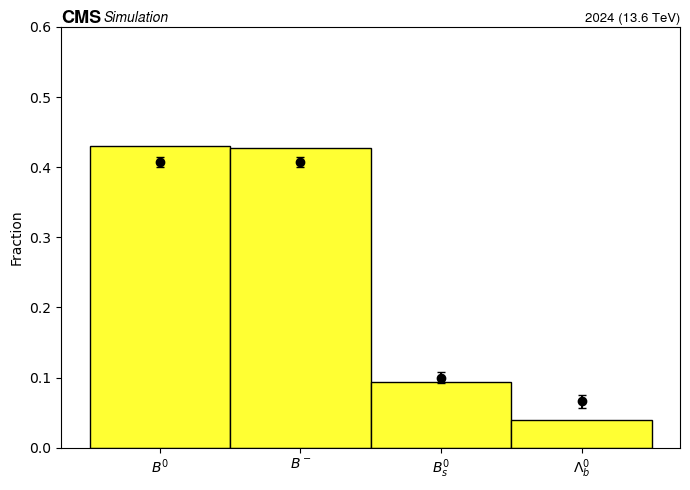

In [11]:
# Define intervals
intervals = np.concatenate((
    np.linspace(0, 5, 2),
    np.linspace(10, 200, 18),
    np.logspace(np.log10(250), np.log10(1000), 6)
))

# Create a class
Hadrons = Production()
Hadrons.Calculate_total(intervals, df_BHad) 

# Add reference values
Hadrons.add_pdgPF(r'$B^0$', 0.408, 0.007, "#e41a1c")
Hadrons.add_pdgPF(r'$B^-$', 0.408, 0.007, "#377eb8")
Hadrons.add_pdgPF(r'$B^0_s$', 0.1, 0.008, "#4daf4a")
Hadrons.add_pdgPF('b-baryon', 0.084, 0.011, "#ffff33")
Hadrons.add_pdgPF(r'$\Lambda^0_b$', 0.066, 0.009, "#ff7f00")

# Plot the histogram
Hadrons.production_fractions(["-51", "-52", "-53", "5122"], [r'$B^0$', r'$B^-$', r'$B^0_s$', r'$\Lambda^0_b$'], [True, True, True, False])

In [12]:
print(Hadrons.scaling_factor.keys())

dict_keys([])


-51
-52
-53


/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_67879/1992749758.py:157: RuntimeWarning: divide by zero encountered in divide
  fracs = values / self.nTotal_array
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_67879/1992749758.py:159: RuntimeWarning: invalid value encountered in sqrt
  CI = Z * np.sqrt((fracs * (1 - fracs)) / Neff)
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_67879/1992749758.py:157: RuntimeWarning: invalid value encountered in divide
  fracs = values / self.nTotal_array


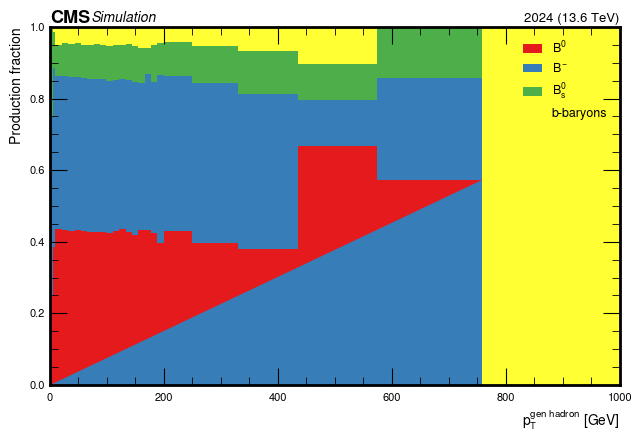

In [13]:
Hadrons.production_fractions_pt(["-51", "-52", "-53"], [r'$B^0$', r'$B^-$', r'$B^0_s$'], ["#e41a1c", "#377eb8", "#4daf4a"])

In [14]:
print(Hadrons.nHadrons.keys())

dict_keys(['$B^0$', '$B^-$', '$B^0_s$', 'OtherMesons'])


15297249.342727661


/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_67879/1992749758.py:273: RuntimeWarning: invalid value encountered in divide
  Neff_Lam = nBaryons**2 / nBaryons_w2
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_67879/1992749758.py:274: RuntimeWarning: invalid value encountered in divide
  BF_Lam = Baryons_pdg * nLambda / nBaryons
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_67879/1992749758.py:302: RuntimeWarning: invalid value encountered in divide
  c0p = nLam * n0s * n_tot / ((n0 + nm) * alpha)
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_67879/1992749758.py:303: RuntimeWarning: invalid value encountered in divide
  c0s = g0s * nLam * n_tot / alpha
/var/folders/s6/9r2gng9n28jfv8k1p2d_82rr0000gn/T/ipykernel_67879/1992749758.py:304: RuntimeWarning: divide by zero encountered in divide
  cLb = gL * n0s * n_tot / alpha


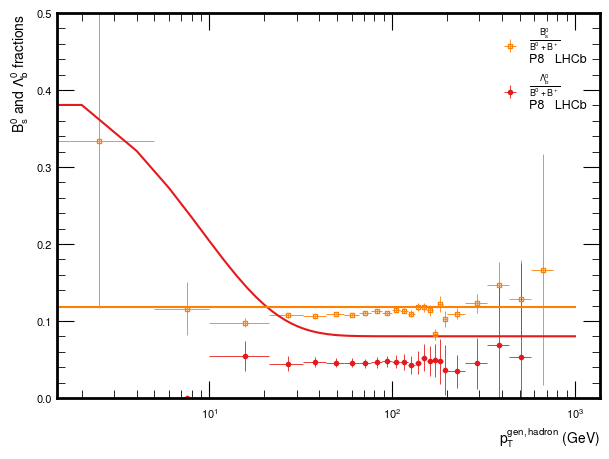

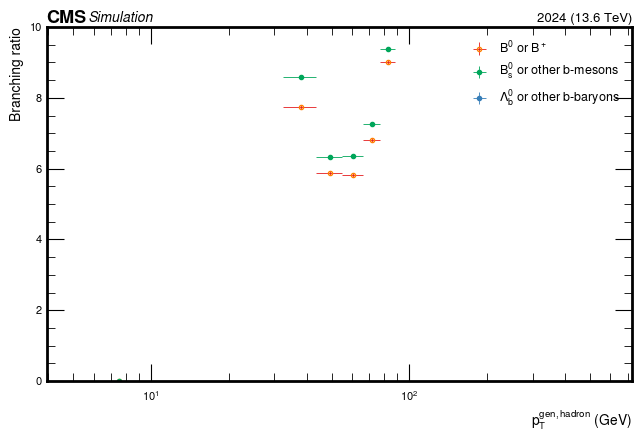

In [15]:
Hadrons.normalized_fractions(intervals, [r'$B^0_s$', r'$B^-$', r'$B^0$'], (0,0.5))